In [1]:
import os
import glob
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from mpi4py import MPI
import ufl

from dolfinx.io import XDMFFile
from dolfinx.fem import (
    functionspace,
    Function,
    assemble_scalar,
    create_interpolation_data,
    form,
)

In [2]:
base_sol_dir = "FEM_Convergence_old/solutions"
results_phi = {}
pattern = re.compile(r"phi_vals_dt([0-9e\.-]+)_ms([0-9\.]+)\.npy$")
for dt_dir in glob.glob(os.path.join(base_sol_dir, "dt_*")):
    for phi_file in glob.glob(os.path.join(dt_dir, "phi_vals_*.npy")):
        fname = os.path.basename(phi_file)
        m = pattern.match(fname)
        if not m:
            continue
        dt_val = float(m.group(1))
        ms_val = float(m.group(2))
        arr = np.load(phi_file)
        results_phi[(dt_val, ms_val)] = arr

if not results_phi:
    raise RuntimeError("No phi‐value .npy files loaded into results_phi.")

In [3]:
slice_dir = "FEM_Convergence_old/slices"
slice_paths = sorted(glob.glob(os.path.join(slice_dir, "sphere_half_xpos_*.xdmf")))
if not slice_paths:
    raise RuntimeError(f"No slice .xdmf files found in {slice_dir!r}")

slice_xdmf_dict = {}
for p in slice_paths:
    fname = os.path.basename(p)
    m = re.match(r"sphere_half_xpos_ms([0-9\.]+)\.xdmf$", fname)
    if m:
        slice_xdmf_dict[float(m.group(1))] = p

In [4]:



full_dir = "FEM_Convergence_old/meshes"
full_paths = sorted(glob.glob(os.path.join(full_dir, "*.xdmf")))
if not full_paths:
    raise RuntimeError(f"No full-sphere .xdmf files found in {full_dir!r}")

mesh_files_dict = {}

full_pattern = re.compile(r"sphere_surface_ms([0-9\.]+)\.xdmf$")
for p in full_paths:
    fname = os.path.basename(p)
    m = full_pattern.match(fname)
    if not m:
        continue
    ms = float(m.group(1))
    mesh_files_dict[ms] = p





mesh_dir = "FEM_Convergence_old/meshes"


xdmf_paths = sorted(glob.glob(os.path.join(mesh_dir, "*.xdmf")))
if not xdmf_paths:
    raise RuntimeError(f"No .xdmf files found in {mesh_dir!r}")


for mesh_path in xdmf_paths:
    fname = os.path.basename(mesh_path)

    m = re.search(r"(?:slice_)?mesh_([^\.]+)\.xdmf$", fname)
    mesh_param = m.group(1) if m else fname.replace(".xdmf", "")

    with XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as xdmf:
        mesh = xdmf.read_mesh()

    ncells = mesh.topology.index_map(mesh.topology.dim).size_global

    print(f"{fname:30s}  →  parameter = {mesh_param:8s}  →  cells = {ncells}")

sphere_surface_ms0.013.xdmf     →  parameter = sphere_surface_ms0.013  →  cells = 176606
sphere_surface_ms0.015.xdmf     →  parameter = sphere_surface_ms0.015  →  cells = 142026
sphere_surface_ms0.016.xdmf     →  parameter = sphere_surface_ms0.016  →  cells = 117170
sphere_surface_ms0.019.xdmf     →  parameter = sphere_surface_ms0.019  →  cells = 83240
sphere_surface_ms0.022.xdmf     →  parameter = sphere_surface_ms0.022  →  cells = 59344
sphere_surface_ms0.035.xdmf     →  parameter = sphere_surface_ms0.035  →  cells = 24632
sphere_surface_ms0.055.xdmf     →  parameter = sphere_surface_ms0.055  →  cells = 10344
sphere_surface_ms0.112.xdmf     →  parameter = sphere_surface_ms0.112  →  cells = 2590


dt=1e-01 → ref ms=0.013, full‐sphere nodes=88305
dt=1e-02 → ref ms=0.013, full‐sphere nodes=88305
dt=1e-03 → ref ms=0.013, full‐sphere nodes=88305


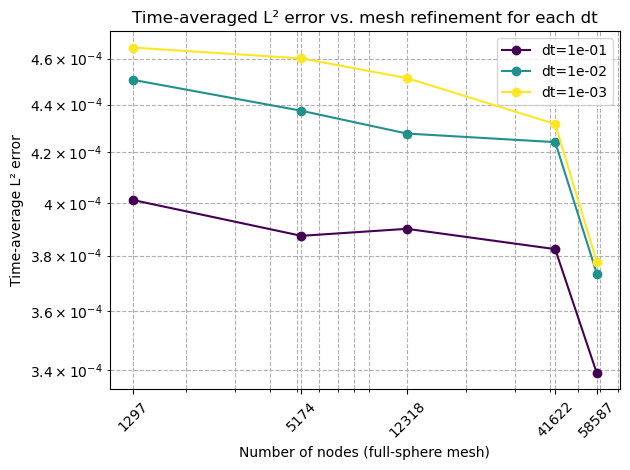

In [5]:
dt_list = [1e-1, 1e-2, 1e-3]
colors  = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))

plt.figure()
for idx_dt, dt in enumerate(dt_list):

    ms_list = sorted([ms for (dt2, ms) in results_phi.keys() if dt2 == dt])
    if not ms_list:
        continue


    ref_ms         = ms_list[0]
    num_time_steps = results_phi[(dt, ref_ms)].shape[0]


    with XDMFFile(MPI.COMM_WORLD, slice_xdmf_dict[ref_ms], "r") as xdmf:
        mesh_ref = xdmf.read_mesh()
    V_ref = functionspace(mesh_ref, ("Lagrange", 1))


    with XDMFFile(MPI.COMM_WORLD, mesh_files_dict[ref_ms], "r") as xdmf:
        full_mesh_ref = xdmf.read_mesh()
    num_full_nodes_ref = full_mesh_ref.geometry.x.shape[0]
    print(f"dt={dt:.0e} → ref ms={ref_ms:.3g}, full‐sphere nodes={num_full_nodes_ref}")

    phi_ref_func = Function(V_ref)
    errors_timeavg = {}


    for ms in ms_list[1:]:

        with XDMFFile(MPI.COMM_WORLD, slice_xdmf_dict[ms], "r") as xdmf:
            mesh_h = xdmf.read_mesh()
        V_h = functionspace(mesh_h, ("Lagrange", 1))


        with XDMFFile(MPI.COMM_WORLD, mesh_files_dict[ms], "r") as xdmf:
            full_mesh = xdmf.read_mesh()
        num_full_nodes = full_mesh.geometry.x.shape[0]


        tdim_h       = mesh_h.topology.dim
        n_cells_h    = mesh_h.topology.index_map(tdim_h).size_local
        cells_h      = np.arange(n_cells_h, dtype=np.int32)
        interp_data  = create_interpolation_data(V_h, V_ref, cells_h)


        phi_ref_on_h = Function(V_h)
        phi_h        = Function(V_h)


        L2_time = np.zeros(num_time_steps)
        for n in range(num_time_steps):

            phi_ref_func.x.array[:] = results_phi[(dt, ref_ms)][n, :].copy()
            phi_ref_on_h.interpolate_nonmatching(phi_ref_func, cells_h, interp_data)


            phi_h.x.array[:] = results_phi[(dt, ms)][n, :].copy()


            u_diff    = phi_h - phi_ref_on_h
            integrand = ufl.inner(u_diff, u_diff) * ufl.ds
            a         = form(integrand, form_compiler_options={"quadrature_degree": 4})
            L2_time[n] = np.sqrt(assemble_scalar(a))

        errors_timeavg[num_full_nodes] = L2_time.mean()


    nodes = sorted(errors_timeavg, reverse=True)
    errs  = [errors_timeavg[n] for n in nodes]
    plt.loglog(nodes, errs, "-o", color=colors[idx_dt], label=f"dt={dt:.0e}")

    ax = plt.gca()
    ax.set_xticks(nodes)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    ax.tick_params(axis="x", rotation=45)

plt.xlabel("Number of nodes (full‐sphere mesh)")
plt.ylabel("Time-average L² error")
plt.title("Time-averaged L² error vs. mesh refinement for each dt")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

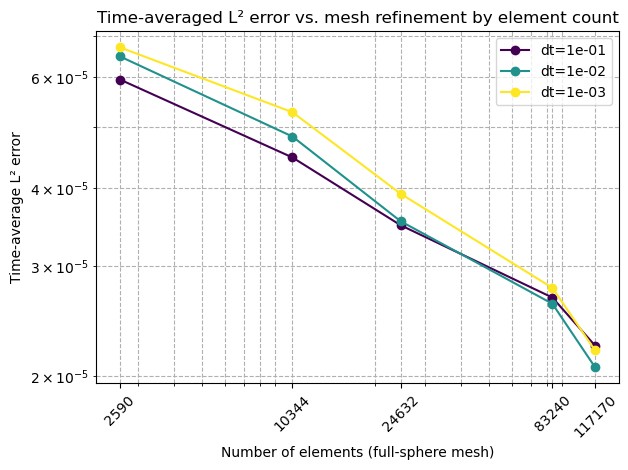

In [6]:


dt_list = [1e-1, 1e-2, 1e-3]
colors  = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))

plt.figure()
for idx_dt, dt in enumerate(dt_list):

    ms_list = sorted([ms for (dt2, ms) in results_phi.keys() if dt2 == dt])
    if not ms_list:
        continue


    ref_ms         = ms_list[0]
    num_time_steps = results_phi[(dt, ref_ms)].shape[0]


    with XDMFFile(MPI.COMM_WORLD, slice_xdmf_dict[ref_ms], "r") as xdmf:
        mesh_ref = xdmf.read_mesh()
    V_ref = functionspace(mesh_ref, ("Lagrange", 1))
    phi_ref_func = Function(V_ref)


    errors_by_elems = {}
    for ms in ms_list[1:]:

        with XDMFFile(MPI.COMM_WORLD, slice_xdmf_dict[ms], "r") as xdmf:
            mesh_h = xdmf.read_mesh()
        V_h = functionspace(mesh_h, ("Lagrange", 1))


        tdim_h    = mesh_h.topology.dim
        n_cells_h = mesh_h.topology.index_map(tdim_h).size_local
        cells_h   = np.arange(n_cells_h, dtype=np.int32)
        interp    = create_interpolation_data(V_h, V_ref, cells_h)

        phi_ref_on_h = Function(V_h)
        phi_h        = Function(V_h)


        L2_time = np.zeros(num_time_steps)
        for n in range(num_time_steps):
            phi_ref_func.x.array[:] = results_phi[(dt, ref_ms)][n, :].copy()
            phi_ref_on_h.interpolate_nonmatching(phi_ref_func, cells_h, interp)
            phi_h.x.array[:] = results_phi[(dt, ms)][n, :].copy()

            diff      = phi_h - phi_ref_on_h
            integrand = ufl.inner(diff, diff) * ufl.dx
            a_form    = form(integrand, form_compiler_options={"quadrature_degree": 4})
            L2_time[n]= np.sqrt(assemble_scalar(a_form))

        timeavg = L2_time.mean()


        with XDMFFile(MPI.COMM_WORLD, mesh_files_dict[ms], "r") as xdmf:
            full_mesh = xdmf.read_mesh()
        num_elems = full_mesh.topology.index_map(full_mesh.topology.dim).size_global

        errors_by_elems[num_elems] = timeavg


    elem_counts = sorted(errors_by_elems.keys(), reverse=True)
    errs        = [errors_by_elems[e] for e in elem_counts]
    plt.loglog(elem_counts, errs, "-o", color=colors[idx_dt], label=f"dt={dt:.0e}")

    ax = plt.gca()
    ax.set_xticks(elem_counts)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    ax.tick_params(axis="x", rotation=45)

plt.xlabel("Number of elements (full‐sphere mesh)")
plt.ylabel("Time-average L² error")
plt.title("Time-averaged L² error vs. mesh refinement by element count")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
elem_counts = {}
for ms, full_path in mesh_files_dict.items():
    with XDMFFile(MPI.COMM_WORLD
            , full_path, "r") as xdmf:
        m_full = xdmf.read_mesh()
    elem_counts[ms] = m_full.topology.index_map(m_full.topology.dim).size_global

elem_counts

{0.013: 176606,
 0.015: 142026,
 0.016: 117170,
 0.019: 83240,
 0.022: 59344,
 0.035: 24632,
 0.055: 10344,
 0.112: 2590}

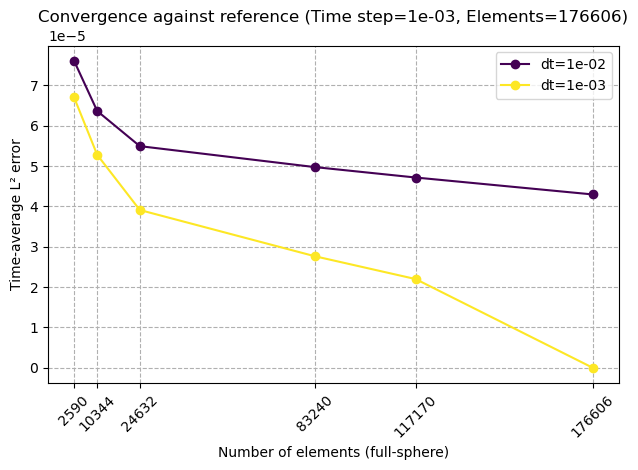

In [26]:
elem_counts = {0.013: 176606,
 0.016: 117170,
 0.019: 83240,
 0.035: 24632,
 0.055: 10344,
 0.112: 2590}



dt_list = [ 1e-2, 1e-3]
dt_ref  = min(dt_list)


ms_ref = min(slice_xdmf_dict.keys())


phi_ref_all = results_phi[(dt_ref, ms_ref)]


with XDMFFile(MPI.COMM_WORLD, slice_xdmf_dict[ms_ref], "r") as xdmf:
    mesh_ref = xdmf.read_mesh()
V_ref = functionspace(mesh_ref, ("Lagrange", 1))


phi_ref_func = Function(V_ref)




results = {dt: {} for dt in dt_list}
for dt in dt_list:

    k = int(round(dt / dt_ref))


    phi_ref_samples = phi_ref_all[k-1::k]


    for ms, slice_path in slice_xdmf_dict.items():

        phi_coarse = results_phi.get((dt, ms))
        if phi_coarse is None:
            continue
        N = phi_coarse.shape[0]
        if phi_ref_samples.shape[0] != N:
            raise RuntimeError(
                f"Reference ({phi_ref_samples.shape[0]}) ≠ "
                f"coarse ({N}) for dt={dt}, ms={ms}"
            )


        with XDMFFile(MPI.COMM_WORLD, slice_path, "r") as xdmf:
            mesh_h = xdmf.read_mesh()
        V_h = functionspace(mesh_h, ("Lagrange", 1))


        tdim_h    = mesh_h.topology.dim
        n_cells_h = mesh_h.topology.index_map(tdim_h).size_local
        cells_h   = np.arange(n_cells_h, dtype=np.int32)
        interp    = create_interpolation_data(V_h, V_ref, cells_h)

        phi_ref_on_h = Function(V_h)
        phi_h        = Function(V_h)


        L2_time = np.zeros(N)
        for n in range(N):

            phi_ref_func.x.array[:] = phi_ref_samples[n].copy()

            phi_ref_on_h.interpolate_nonmatching(phi_ref_func, cells_h, interp)


            phi_h.x.array[:] = phi_coarse[n].copy()


            diff      = phi_h - phi_ref_on_h
            integrand = ufl.inner(diff, diff) * ufl.dx
            a_form    = form(integrand, form_compiler_options={"quadrature_degree": 4})
            L2_time[n]= np.sqrt(assemble_scalar(a_form))


        T = N * dt
        E = np.trapz(L2_time, dx=dt) / T
        results[dt][elem_counts[ms]] = E


plt.figure()
colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))
for idx, dt in enumerate(dt_list):
    ec = results[dt]
    x = sorted(ec.keys())
    y = [ec[e] for e in x]
    plt.plot(x, y, "-o", color=colors[idx], label=f"dt={dt:.0e}")

ax = plt.gca()
ax.set_xticks(sorted(set().union(*[set(r.keys()) for r in results.values()])))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))
ax.tick_params(axis="x", rotation=45)
ref_elems = elem_counts[ms_ref]
plt.xlabel("Number of elements (full-sphere)")
plt.ylabel("Time‐average L² error")
plt.title(
    f"Convergence against reference "
    f"(Time step={dt_ref:.0e}, Elements={ref_elems:d})")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

Use             integrand = ufl.inner(diff, diff) * ufl.dx
for boundary calculation and more dramatic result 

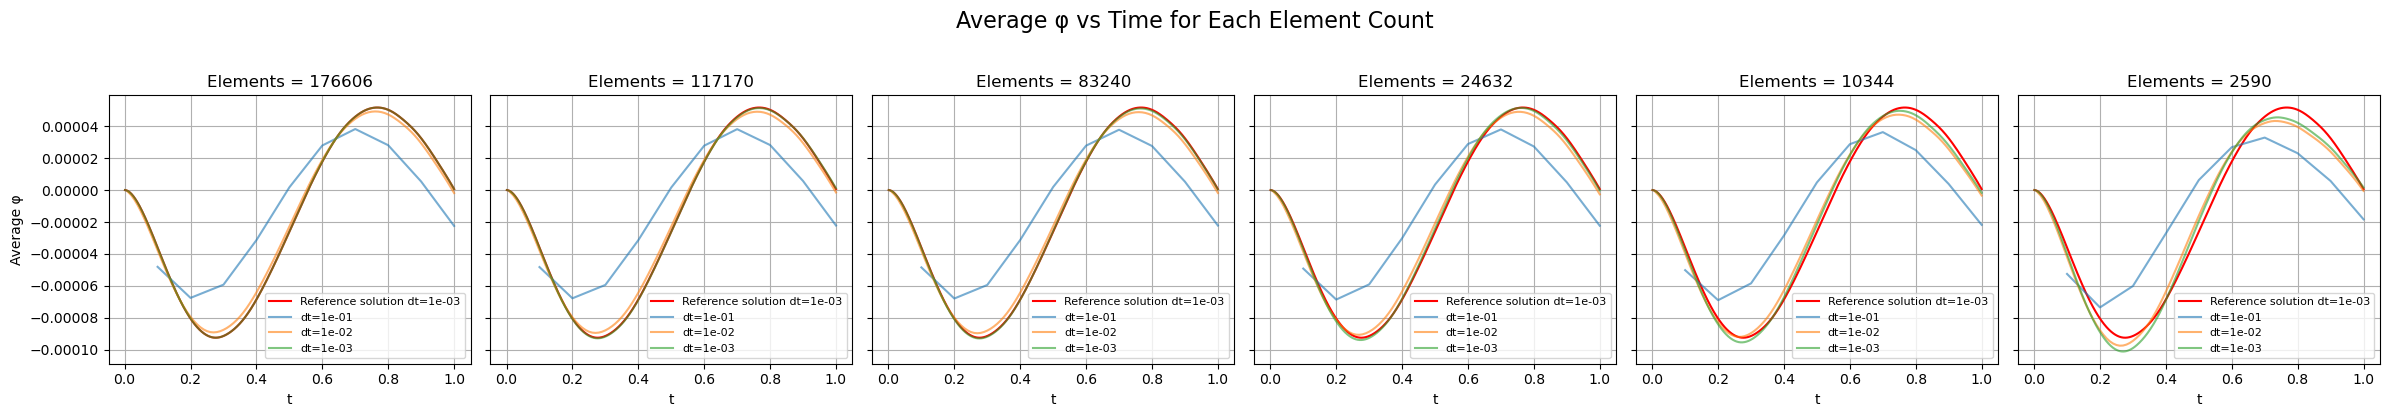

In [24]:
import numpy as np
import matplotlib.pyplot as plt



dt_list = [0.1, 0.01, 0.001]


elem_counts = {
    0.013: 176606,
    0.016: 117170,
    0.019: 83240,
    0.035: 24632,
    0.055: 10344,
    0.112: 2590
}


ms_list = sorted(
    {ms for dt, ms in results_phi.keys() if dt in dt_list},
    key=lambda m: elem_counts[m],
    reverse=True
)


dt_ref = min(dt_list)
ms_ref = ms_list[0]


phi_ref = results_phi[(dt_ref, ms_ref)]
N_ref = phi_ref.shape[0]
t_ref = np.linspace(dt_ref, dt_ref * N_ref, N_ref)
phi_ref_mean = phi_ref.mean(axis=1)


fig, axes = plt.subplots(1, len(ms_list), figsize=(4 * len(ms_list), 4), sharey=True)
fig.suptitle("Average phi vs Time for Each Element Count", fontsize=16, y=1.03)

for ax, ms in zip(axes, ms_list):

    ax.plot(t_ref, phi_ref_mean, '-', color='red', alpha=1,
            label=f"Reference solution dt={dt_ref:.0e}")


    for dt in dt_list:
        phi = results_phi.get((dt, ms))
        if phi is None:
            continue
        N = phi.shape[0]
        t = np.linspace(dt, dt * N, N)
        phi_mean = phi.mean(axis=1)
        ax.plot(t, phi_mean, alpha=0.6, label=f"dt={dt:.0e}")

    ax.set_title(f"Elements = {elem_counts[ms]:.0f}")
    ax.set_xlabel("t")
    ax.grid(True)
    ax.legend(fontsize=8)

axes[0].set_ylabel("Average phi")
plt.tight_layout()
plt.show()

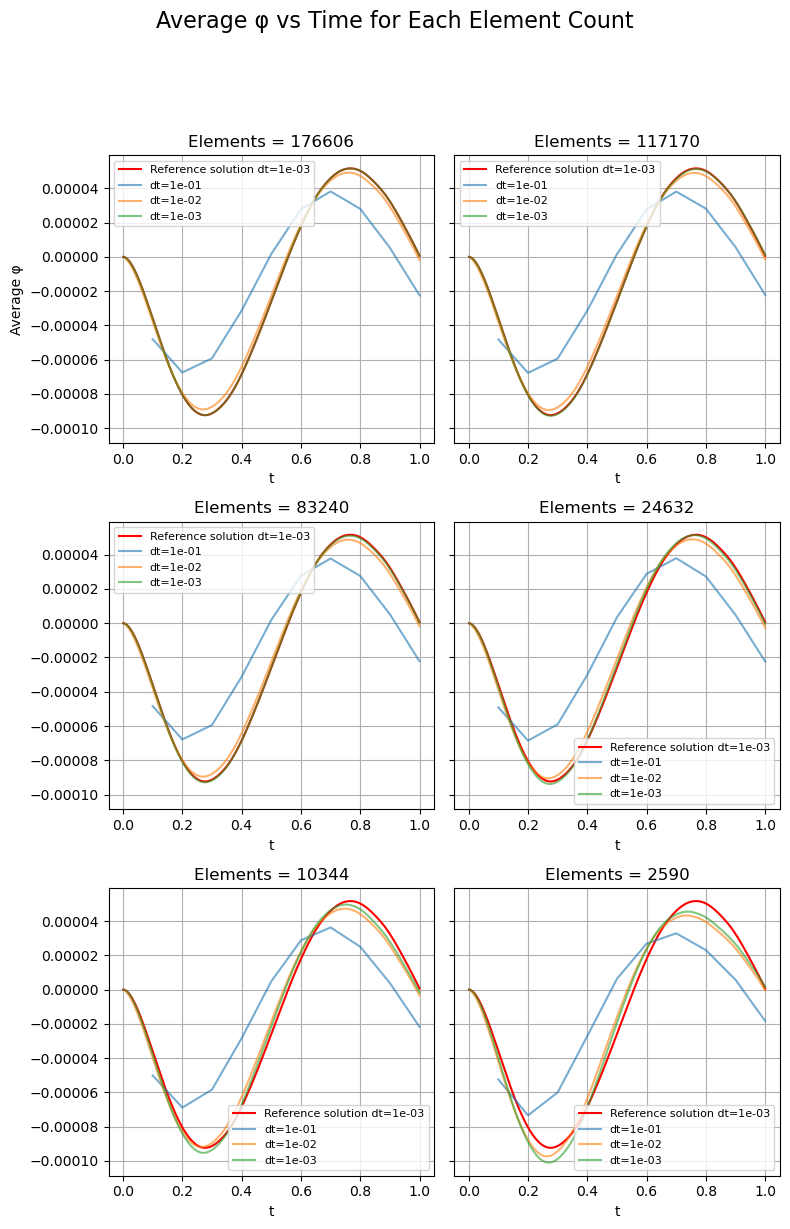

In [25]:
import numpy as np
import matplotlib.pyplot as plt

dt_list = [0.1, 0.01, 0.001]

elem_counts = {
    0.013: 176606,
    0.016: 117170,
    0.019: 83240,
    0.035: 24632,
    0.055: 10344,
    0.112: 2590
}

ms_list = sorted(
    {ms for dt, ms in results_phi.keys() if dt in dt_list},
    key=lambda m: elem_counts[m],
    reverse=True
)

dt_ref = min(dt_list)
ms_ref = ms_list[0]

phi_ref = results_phi[(dt_ref, ms_ref)]
N_ref = phi_ref.shape[0]
t_ref = np.linspace(dt_ref, dt_ref * N_ref, N_ref)
phi_ref_mean = phi_ref.mean(axis=1)


ncols = 2
nrows = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharey=True)
fig.suptitle("Average phi vs Time for Each Element Count", fontsize=16, y=1.02)


axes = axes.flatten()

for ax, ms in zip(axes, ms_list):
    ax.plot(t_ref, phi_ref_mean, '-', color='red', alpha=1,
            label=f"Reference solution dt={dt_ref:.0e}")
    for dt in dt_list:
        phi = results_phi.get((dt, ms))
        if phi is None:
            continue
        N = phi.shape[0]
        t = np.linspace(dt, dt * N, N)
        phi_mean = phi.mean(axis=1)
        ax.plot(t, phi_mean, alpha=0.6, label=f"dt={dt:.0e}")
    ax.set_title(f"Elements = {elem_counts[ms]:.0f}")
    ax.set_xlabel("t")
    ax.grid(True)
    ax.legend(fontsize=8)


for ax in axes[len(ms_list):]:
    ax.axis('off')

axes[0].set_ylabel("Average phi")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()